### Классификация имён с помощью RNN
#### Thank you,  Sean Robertson :https://github.com/spro/practical-pytorch

## 1.Подготовка данных

In [22]:
import glob
all_filenames = glob.glob('../../../data/names/*.txt')

In [23]:
print(all_filenames)

['../../../data/names/Greek.txt', '../../../data/names/Polish.txt', '../../../data/names/Spanish.txt', '../../../data/names/Italian.txt', '../../../data/names/Arabic.txt', '../../../data/names/Korean.txt', '../../../data/names/English.txt', '../../../data/names/Czech.txt', '../../../data/names/Irish.txt', '../../../data/names/Dutch.txt', '../../../data/names/Vietnamese.txt', '../../../data/names/Portuguese.txt', '../../../data/names/Japanese.txt', '../../../data/names/Russian.txt', '../../../data/names/Scottish.txt', '../../../data/names/Chinese.txt', '../../../data/names/French.txt', '../../../data/names/German.txt']


In [24]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [27]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


### Теперь у нас есть отображение: Язык$\longrightarrow$Список имён, принаджежащих языку.

In [29]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Теперь сформируем тензор, из это списка

In [30]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [33]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


### Создание сети:


In [39]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


In [40]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [48]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [49]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8419, -2.7687, -2.9836, -2.9232, -2.8517, -2.8762, -2.9262, -2.9213,
         -2.8463, -2.8988, -2.8900, -2.9592, -2.8762, -2.8589, -2.9541, -2.8380,
         -3.0167, -2.8280]], grad_fn=<LogSoftmaxBackward>)


/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Подготовка к обучению

In [50]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Polish', tensor(1))


In [52]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Russian / line = Vyaltsin
category = Irish / line = Nuallan
category = Russian / line = Yakunov
category = Greek / line = Pispinis
category = Irish / line = Gerald
category = Chinese / line = Bei
category = Scottish / line = Christie
category = Vietnamese / line = Duong
category = Russian / line = Harmansky
category = Vietnamese / line = Dinh


### Обучение
В качестве функции ошибок выберем nn.NLLLOSS

In [53]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [54]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [55]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


5000 5% (0m 6s) 3.3987 Oesterreicher / Greek ✗ (Czech)
10000 10% (0m 12s) 2.2831 Leeuwenhoek / Polish ✗ (Dutch)
15000 15% (0m 19s) 0.5132 Katsushika / Japanese ✓
20000 20% (0m 25s) 2.8655 Jems / Korean ✗ (English)
25000 25% (0m 31s) 2.7173 Souza / Arabic ✗ (Portuguese)
30000 30% (0m 37s) 1.8045 Perrett / French ✗ (English)
35000 35% (0m 43s) 0.9980 Bradan / Irish ✓
40000 40% (0m 49s) 1.5702 Saliba / Arabic ✓
45000 45% (0m 55s) 0.7742 Zientek / Polish ✓
50000 50% (1m 1s) 0.4093 Faolan / Irish ✓
55000 55% (1m 6s) 1.2963 Victors / French ✓
60000 60% (1m 12s) 0.6851 Hiu / Chinese ✓
65000 65% (1m 20s) 1.8519 Wrenn / Scottish ✗ (English)
70000 70% (1m 26s) 4.2576 Leitzke / Polish ✗ (German)
75000 75% (1m 32s) 0.3636 Davidson / Scottish ✓
80000 80% (1m 38s) 0.4443 Ping / Chinese ✓
85000 85% (1m 46s) 1.5695 Abasolo / Italian ✗ (Spanish)
90000 90% (1m 51s) 1.1591 Nunes / Portuguese ✓
95000 95% (1m 57s) 3.3571 Marr / German ✗ (English)
100000 100% (2m 3s) 2.2163 Goebel / Spanish ✗ (German)


### Графики результатов

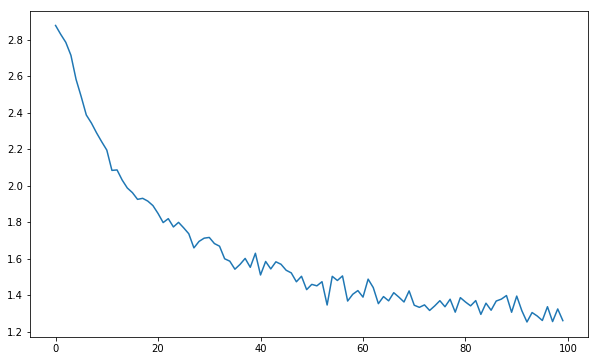

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)
plt.figure()
plt.plot(all_losses);

### Оценка результатов

/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


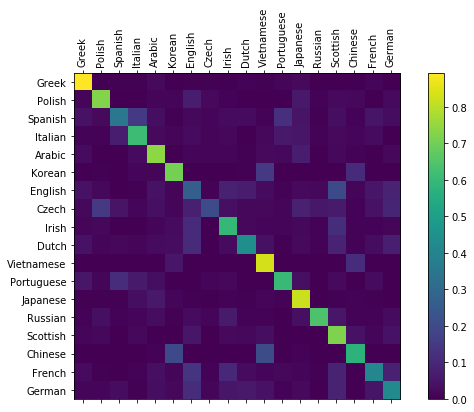

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [61]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [62]:
predict('Erlygin')


> Erlygin
(-1.04) Russian
(-1.53) English
(-1.54) Irish


/home/leonid/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
